In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [70]:
#System setup
from scipy.constants import speed_of_light
freq = 28e9
wavelength = speed_of_light/freq

#Antenna aperture
Ae = (48*0.5*wavelength)*(24*0.5*wavelength)
# Gain of transmit antenna
Gt = (4*np.pi*Ae)/(wavelength**2)
Gt_dB = 10*np.log10(Gt)

# Gain of receive antenna
Gr = Gt
print(f"Antenna gain: {Gt_dB} dBi")

# Transmit power, dBm
Pt_dBm = 39
Pt = np.power(10, Pt_dBm/10)

#Sensing requirements
# Probability of detection
Pd = 0.99
# Probability of False Alarm
Pfa_detect = 0.05
Pfa_track = 10e-3


Antenna gain: 35.586023517813274 dBi


Noise level in required bandwidth: -89.20698016494883  dBm


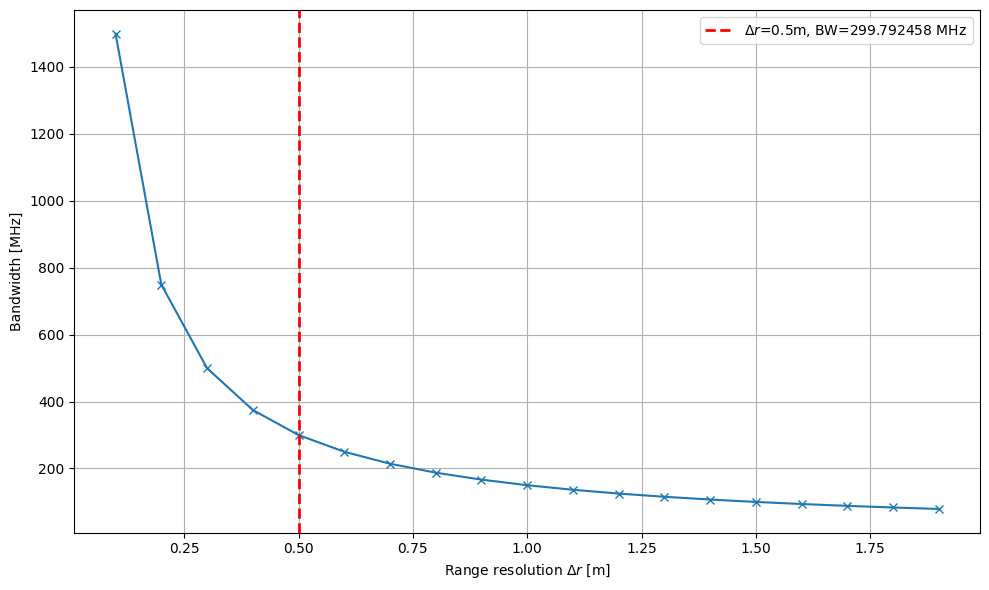

In [87]:
# Determine bandwidth of operation
# Bandwidth affects range resolution, what bandwidth is required to achieve 1-5cm of range resolution
req_delta_r = 0.5

delta_r = np.arange(0.1, 2, 0.1)
bw = speed_of_light/(2*delta_r)
plt.figure(figsize=(10, 6))
plt.plot(delta_r, bw/1e6, marker='x')
req_bandwidth = int(np.round(bw[np.where(delta_r==req_delta_r)[0]][0]))
label_str = r'$\Delta r$' + f'=0.5m, BW={req_bandwidth/1e6} MHz'
plt.axvline(x=0.5, color='r', linestyle='--', linewidth=2, label=label_str)
plt.legend()
plt.xlabel('Range resolution ' + r'$\Delta r$' + ' [m]')
plt.ylabel('Bandwidth [MHz]')
plt.tight_layout()
plt.grid()

# For the required bandwidth, calculate the thermal noise floor
from scipy.constants import k
Ts = 290
N = k * Ts * req_bandwidth
N_dBm = 10*np.log10(N) + 30
print(f'Noise level in required bandwidth: {N_dBm}  dBm')

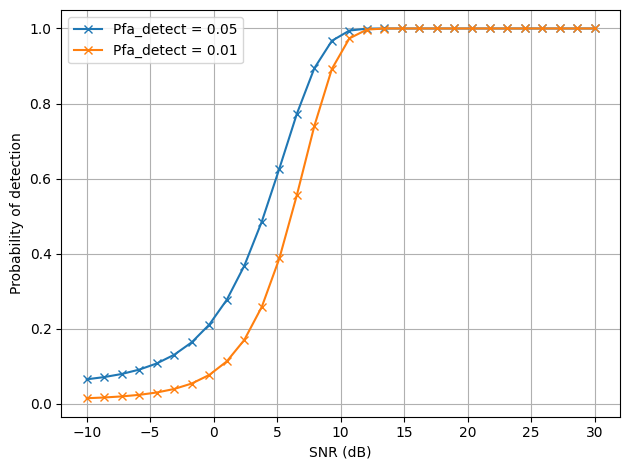

In [97]:
# For a given detection probability and probability of false alarm, determine the SNR required
# Multiple methods can be used to determine the minimum SNR required for CFAR (Constant False Alarm Rate)
# Marcum q function
def marcumq(a, x, m=1):
    from scipy.stats import distributions
    """
    Calculates the generalized Marcum Q function.

    The Marcum Q function is defined as:
        Q_m(a, x) = 1 - F_ncx2(m * 2, a^2, x^2)

    :param float a: Non-centrality parameter.
    :param float x: Threshold value.
    :param int m: Order of the function, positive integer (default is 1).

    :return: Generalized Marcum Q function value.
    :rtype: float

    :references:
        - `Wikipedia - Marcum Q-function <https://en.wikipedia.org/wiki/Marcum_Q-function>`_
        - `SciPy Documentation - scipy.stats.ncx2
            <https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ncx2.html>`_
    """
    return 1 - distributions.ncx2.cdf(df=m * 2, nc=a**2, x=x**2)

snr_sweep_dB = np.linspace(-10, 30, 30)
snr_sweep = np.power(10, snr_sweep_dB/10)
pd_detect = marcumq(np.sqrt(2*snr_sweep), np.sqrt(-2*np.log(Pfa_detect)))
plt.plot(snr_sweep_dB, pd_detect, marker='x', label=r'Pfa_detect ' + f'= {Pfa_detect}')

pd_track = marcumq(np.sqrt(2*snr_sweep), np.sqrt(-2*np.log(Pfa_track)))
plt.plot(snr_sweep_dB, pd_track, marker='x', label=r'Pfa_detect ' + f'= {Pfa_track}')

plt.xlabel(r'SNR (dB)')
plt.ylabel('Probability of detection')
plt.legend()
plt.grid()
plt.tight_layout()

In [98]:
req_min_snr_detect = np.min(snr_sweep_dB[np.where(pd_detect >= 0.99)[0]])
print(f'SNR detect: {req_min_snr_detect}')

req_min_snr_track = np.min(snr_sweep_dB[np.where(pd_track >= 0.99)[0]])
print(f'SNR detect: {req_min_snr_detect}')

SNR detect: 10.689655172413794
SNR detect: 10.689655172413794


In [106]:
10*np.log10((speed_of_light**2)/(8*(np.pi**2)*(req_bandwidth**2)*200*(delta_r**2)))

array([-21.98419728, -28.00479719, -31.52662237, -34.02539711,
       -35.96359737, -37.54722229, -38.88615808, -40.04599702,
       -41.06904747, -41.98419728, -42.81205098, -43.5678222 ,
       -44.26306433, -44.90675799, -45.50602246, -46.06659693,
       -46.59317571, -47.08964738, -47.5592693 ])

In [90]:
#Radar equation
R = np.linspace(50,1000, 400)
sigma_rcs = 0.01
Pr = ((Pt * Gt)/(4 * np.pi * (R**2))) * (Ae/(4 * np.pi * (R**2)))
Pr_dBm = 10*np.log10(Pr)

In [ ]:
# Start with sensing requirements
# 1. Positioning accuracy: 10-30 cm/5-10 cm, 2. Range resolution: 1-5cm, 3. Velocity resolution: 0.1 to 0.5m/s 4. AoA accuracy: 1-5 degrees
# 5. Pd/Probability of detection: 99% or .99, 6. Probability of False Alarm: 10e-3 to 10e-5

# Range resolution
# Completely dependent on bandwidth of the system, Ability to differentiate between two delays is dependent on bandwidth
